In [1]:
import pandas as pd
import numpy as np
import math

Задание 1 Предложить метрику, описывающую сложность уровней, и рассчитать ее.

Задание 2 По результатам предыдущего задания разделить уровни на группы по сложности и сделать вывод о плотности расположения сложных уровней в игре. Задание 3 Рассчитать "воронку" прохождения уровней новым пользователем после установки игры. Также мы хотели бы получить от вас комментарий по выполнению тестового задания. Он не должен быть очень большим. Нам интересно было бы узнать:

примерную оценку времени, которое вы потратили на выполнение задания;
комментарии по сформированной метрике (п1): почему данная метрика будет показательной;
возникали ли проблемы при выполнении тестового задания.

Входные данные — файл plr_smpl_attempts.csv.gz, содержащий лог событий за определенный промежуток времени по первым 500 уровням в игре. Файл содержит четыре колонки:
❏ uid — уникальный id игрока;
❏ action — ‘completed’ для успешной попытки прохождения уровня, ‘failed’ для неуспешной;
❏ level — уровень, на котором произошло событие;
❏ event_time — event_time/1000 является unix timestamp времени получения события.

In [2]:
df = pd.read_csv("C:/Users/Mr0Wo/OneDrive/Рабочий стол/Git_repositories/Data-science-cases/Analytical-cases/Game-dev-case/plr_smpl_attempts.csv.gz", sep=';')
df.head()

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [3]:
len(df)

22231214

In [4]:
df.action.value_counts(normalize=True)

failed       0.843163
completed    0.156837
Name: action, dtype: float64

In [5]:
df['datetime'] = pd.to_datetime(df.event_time, unit='ms')

In [6]:
df.head()

,uid,action,level,event_time,datetime
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,2017-12-01 00:08:44.640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,2017-12-01 00:08:44.640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,2017-12-01 00:08:44.640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,2017-12-01 00:08:44.640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,2017-12-01 00:08:44.640


In [7]:
level_success_rate = df.pivot_table(index='level', columns='action', values='uid', aggfunc='count')
level_success_rate

action,completed,failed
level,,
1,25140,17
2,22436,877
3,21687,1947
4,21322,314
5,20769,6423
...,...,...
496,419,1643
497,411,737
498,400,2009


In [8]:
level_success_rate['success_rate'] = np.round(level_success_rate['completed'] / (level_success_rate['completed'] + level_success_rate['failed']),2)

In [9]:
level_success_rate = level_success_rate.reset_index()

In [10]:
df['action'] = df['action'].map({'completed':1, 'failed':0})

In [11]:
one_try_users = df.groupby(['level', 'uid'])['action'] \
                        .apply(list) \
                        .apply(math.prod) \
                        .reset_index() \
                        .groupby('level')['action'] \
                        .sum() \
                        .reset_index() \
                        .rename(columns={'action' : 'one_try_users'})

In [12]:
level_users_count = df.groupby('level')['uid'].nunique().reset_index()

In [13]:
one_try_users = one_try_users.merge(level_users_count)

In [14]:
one_try_users['%_of_one_try_users'] = np.round(one_try_users['one_try_users'] / one_try_users['uid'],2)
one_try_users.head()

,level,one_try_users,uid,%_of_one_try_users
0,1,24151,24162,1.00
1,2,21505,22177,0.97
2,3,19818,21415,0.93
3,4,20674,20916,0.99
4,5,16254,20625,0.79


In [15]:
df['uid'].nunique()

196088

In [16]:
df.groupby('level')['uid'].nunique()

level
1      24162
2      22177
3      21415
4      20916
5      20625
       ...  
496      433
497      408
498      412
499      407
500      429
Name: uid, Length: 500, dtype: int64

In [17]:
df.groupby('level')['action'].apply(list).str.len()

level
1      25157
2      23313
3      23634
4      21636
5      27192
       ...  
496     2062
497     1148
498     2409
499     1424
500     3526
Name: action, Length: 500, dtype: int64

In [18]:
nunique_uid = df.groupby('level')['uid'].nunique().reset_index()

In [19]:
nunique_uid.rename(columns={'uid':'nunique_uid'},inplace=True)

<Axes: xlabel='level'>

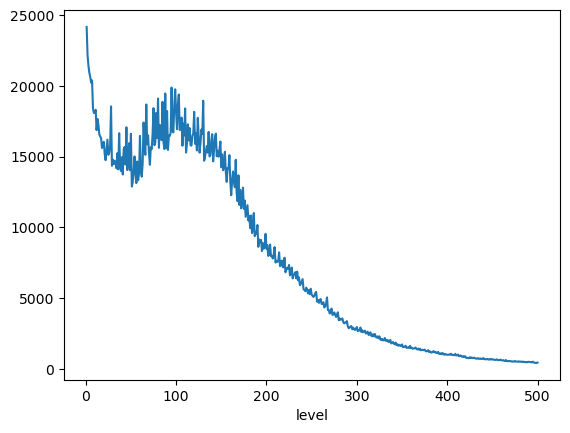

In [20]:
df.groupby('level')['uid'].nunique().plot()

## Метрики:
### 1. success_rate = completed / (completed + failed)
### 2. %_of_one_try_users = игроки прошедшие уровень с 1 попытки / кол-во всех игроков, которые совершили какое-либо action на уровне
### 3. Кол-во уникальных пользователей на уровне 

In [21]:
metrics = pd.DataFrame(list(range(1,501))).rename(columns={0:'level'})

In [22]:
metrics = metrics.merge(one_try_users[['level', '%_of_one_try_users']])

In [23]:
metrics = metrics.merge(level_success_rate[['level', 'success_rate']])

In [24]:
metrics = metrics.merge(nunique_uid)

In [25]:
metrics

,level,%_of_one_try_users,success_rate,nunique_uid
0,1,1.00,1.00,24162
1,2,0.97,0.96,22177
2,3,0.93,0.92,21415
3,4,0.99,0.99,20916
4,5,0.79,0.76,20625
...,...,...,...,...
495,496,0.19,0.20,433
496,497,0.36,0.36,408
497,498,0.20,0.17,412
498,499,0.29,0.29,407


# Задание 2


<Axes: >

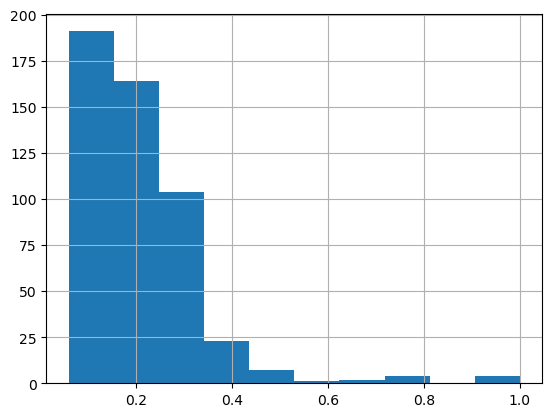

In [26]:
metrics['success_rate'].hist()

<Axes: >

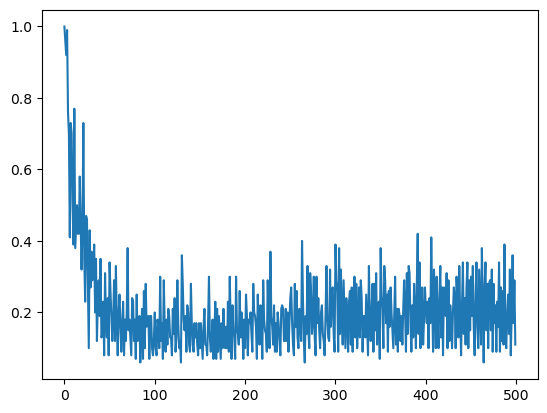

In [27]:
metrics['success_rate'].plot()

<Axes: >

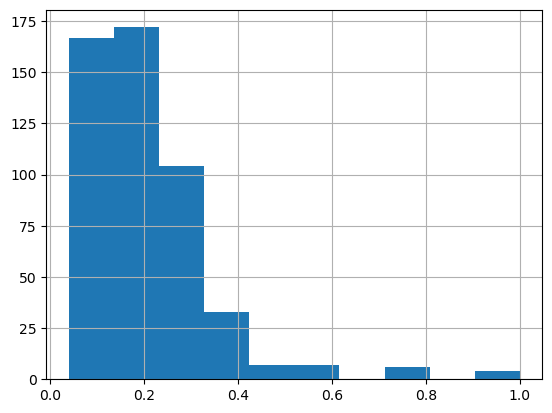

In [28]:
metrics['%_of_one_try_users'].hist()

<Axes: >

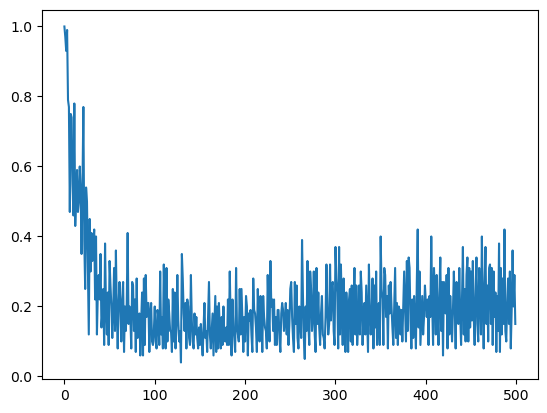

In [29]:
metrics['%_of_one_try_users'].plot()

In [30]:
metrics['success_rate_complexity'] =   np.where(metrics['success_rate']<=0.2, 3,
                                       np.where(((metrics['success_rate']<=0.4) & (metrics['success_rate']>0.2)),2,
                                       np.where(metrics['success_rate']>0.4,1,0)))

In [31]:
metrics['%_of_one_try_users_complexity'] =   np.where(metrics['%_of_one_try_users']<=0.2, 3,
                                       np.where(((metrics['%_of_one_try_users']<=0.4) & (metrics['success_rate']>0.2)),2,
                                       np.where(metrics['%_of_one_try_users']>0.4,1,4)))

In [55]:
metrics[metrics['%_of_one_try_users_complexity'] == 4]

,level,%_of_one_try_users,success_rate,nunique_uid,success_rate_complexity,%_of_one_try_users_complexity
34,35,0.22,0.20,15227,3,4
39,40,0.22,0.19,14952,3,4
60,61,0.21,0.20,13955,3,4
64,65,0.22,0.17,15717,3,4
69,70,0.21,0.20,15242,3,4
78,79,0.22,0.18,16302,3,4
92,93,0.21,0.18,16450,3,4
93,94,0.21,0.19,16699,3,4
96,97,0.21,0.19,16702,3,4
113,114,0.31,0.18,16138,3,4


<Axes: xlabel='level', ylabel='success_rate_complexity'>

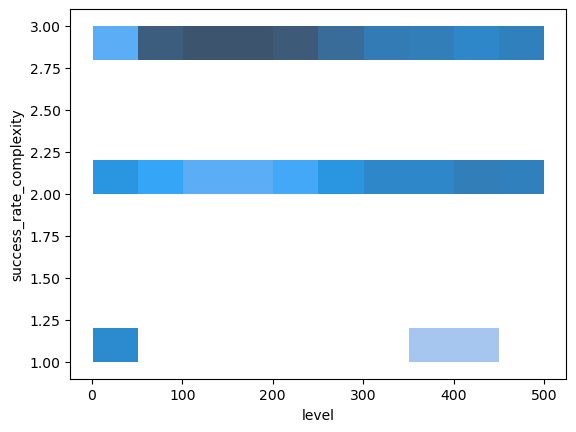

In [33]:
import seaborn as sns
sns.histplot(data=metrics, x='level', y='success_rate_complexity')

<Axes: xlabel='level', ylabel='%_of_one_try_users_complexity'>

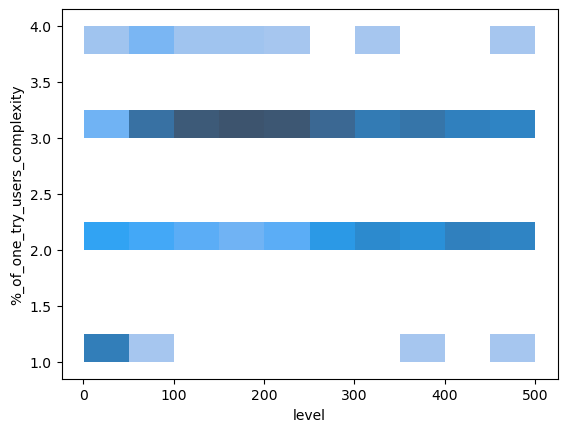

In [34]:
sns.histplot(data=metrics, x='level', y='%_of_one_try_users_complexity')

## Из графиков видно, что в районе уровней 150-250 находится большое скопление сложных уровней

# Задание 3

In [35]:
df['uid'].nunique()

196088

In [52]:
t = df.merge(df[df.level == 1]['uid']).groupby('uid')['level'].apply(list).apply(max)

<Axes: >

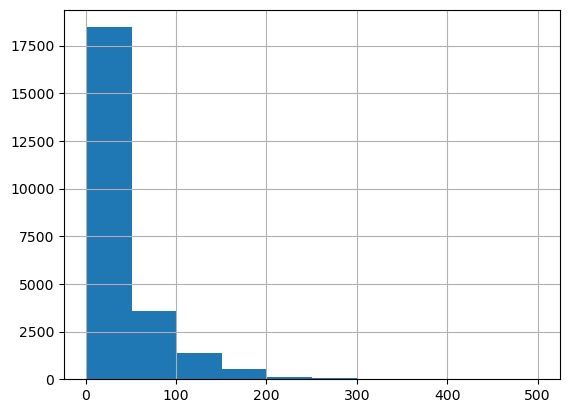

In [63]:
t.hist()

# Выводы

1. Были предложены 2 основые метрики: % успешных прохождений уровня и % игроков, прощедших уровень с первой попытки  

success_rate = completed / (completed + failed)

%_of_one_try_users = игроки, у которых на уровне нет action = falied / кол-во всех игроков, у которых было какое-либо action на уровне

2. Было проанализировано распределение уровней по сложностям.   
0 - 50: практически нет проблем с прохождением (легкие уровни)    
50 - 100: уровни вызывают проблемы, наблюдаются как средние, так и сложные уровни  
100 - 250: наблюдаются значительные проблемы с прохождением (сложные уровни)  
250 - 500: примерно равнораспределены между средними и сложными уровнями   

3. Огромная часть новых пользователей отваливается до 50 уровня, далее так же наблюдается спад после 100 уровня. Оставшиеся игрои распределены примерно равномерно